In [2]:
import random
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from statistics import mode
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense, Activation, LSTM, GRU, SimpleRNN, Conv1D, TimeDistributed, MaxPooling1D, Flatten, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Hyperparameter
import ray
from ray import train, tune
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.air.integrations.keras import ReportCheckpointCallback

from tensorflow.keras.optimizers import Adam, RMSprop
from functools import partial
from ray.tune.schedulers import ASHAScheduler


# Setting the random seeds for reproductibility
np.random.seed(42)
random.seed(42)

/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-12 21:41:17,966	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-12 21:41:18,246	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-12 21:41:18,373	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


# Read Data Files

In [3]:

# File paths
file_path_healthy5 = './HIL Data 062024/ACC faults different scenarios/Sc5Healthy.csv'
file_path_delay5 = './HIL Data 062024/ACC faults different scenarios/Sc5DelayAPP.csv'
file_path_gain5 = './HIL Data 062024/ACC faults different scenarios/SC5GainAPP.csv'
file_path_noise5 = './HIL Data 062024/ACC faults different scenarios/Sc5NoiseAPP.csv'
file_path_loss5 = './HIL Data 062024/ACC faults different scenarios/Sc5PacketLossAPP.csv'

file_path_healthy4 = './HIL Data 062024/ACC faults different scenarios/Sc4Healthy.csv'
file_path_delay4 = './HIL Data 062024/ACC faults different scenarios/Sc4DelayApp.csv'
file_path_gain4 = './HIL Data 062024/ACC faults different scenarios/Sc4GainAPP.csv'
file_path_noise4 = './HIL Data 062024/ACC faults different scenarios/Sc4NoiseAPP.csv'
file_path_loss4 = './HIL Data 062024/ACC faults different scenarios/SC4PacketLossAPP.csv'

file_path_healthy3 = './HIL Data 062024/ACC faults different scenarios/Sc3_Healthy.csv'
file_path_delay3 = './HIL Data 062024/ACC faults different scenarios/Sc3DelayAPP.csv'
file_path_gain3 = './HIL Data 062024/ACC faults different scenarios/Sc3GainAPP.csv'
file_path_noise3 = './HIL Data 062024/ACC faults different scenarios/Sc3_Noise_APP_50.csv'
file_path_loss3 = './HIL Data 062024/ACC faults different scenarios/Sc3PacketlossAPP.csv'

file_path_healthy2 = './HIL Data 062024/ACC faults different scenarios/SC2_healthy.csv'
file_path_delay2 = './HIL Data 062024/ACC faults different scenarios/Sc2_APP_Delay.csv'
file_path_gain2 = './HIL Data 062024/ACC faults different scenarios/gainAPP_High_50.csv'
file_path_noise2 = './HIL Data 062024/ACC faults different scenarios/Sc2_Noise-APP.csv'
file_path_loss2 = './HIL Data 062024/ACC faults different scenarios/PacketLossAPP.csv'

#TEST DATA
file_path_gainRPM_delayAPP = './HIL Data 062024/ACC faults different scenarios/Sc3_Healthy.csv'
file_path_gainRPM_noiseAPP = './HIL Data 062024/ACC faults different scenarios/Sc3_Noise-APP_50.csv'
file_path_gainRPM_packetlossAPP = './HIL Data 062024/ACC faults different scenarios/Sc3PacketlossAPP.csv'

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Function to parse the general information section


def parse_general_info(lines):
    general_info = {}
    for line in lines:
        parts = line.split('\t')
        if len(parts) >= 3:
            category, key, value = parts[0], parts[1], parts[2]
            if category == "General":
                general_info[key] = value
    return general_info

# Function to parse the trace information section


def parse_trace_info(lines):
    trace_info = {}
    headers = lines[0].split('\t')
    for line in lines[1:]:
        values = line.split('\t')
        for i, header in enumerate(headers):
            if i < len(values):
                if header not in trace_info:
                    trace_info[header] = []
                trace_info[header].append(values[i])
    return trace_info

# Function to parse the trace values section


def parse_trace_values(lines):
    trace_values = [line.split(',') for line in lines]
    df = pd.DataFrame(trace_values[1:], columns=trace_values[0])
    return df

# Read the text data


def read_this(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Parse sections
    general_info_lines = []
    trace_info_lines = []
    trace_values_lines = []
    current_section = None

    for line in lines:
        line = line.strip()
        if 'descriptions' in line:
            current_section = 'general_info'
        elif 'trace_size' in line:
            current_section = 'trace_info'
        elif 'trace_values' in line:
            current_section = 'trace_values'
        elif line:
            if current_section == 'general_info':
                general_info_lines.append(line)
            elif current_section == 'trace_info':
                trace_info_lines.append(line)
            elif current_section == 'trace_values':
                trace_values_lines.append(line)

    # Process sections
    general_info = parse_general_info(general_info_lines)
    trace_info = parse_trace_info(trace_info_lines)
    trace_values = parse_trace_values(trace_values_lines).values.flatten()

    cleaned_trace_values = []

    for x in trace_values:
        try:
            cleaned_trace_values.append(float(x))
        except ValueError:
            pass

    return general_info, trace_info, np.array(cleaned_trace_values)

# Function to pad data to the reference length


def pad_data(data, ref_length):
    padded_data = np.pad(
        data, (0, max(0, ref_length - len(data))), 'constant', constant_values=np.nan)
    return padded_data[:ref_length]

In [5]:
read_this(file_path_healthy5)[2]

array([1.15201100e-01, 1.51732799e+00, 7.31739848e+02, ...,
       6.27157161e+04, 1.19892780e+02, 1.13901583e+02])

In [6]:
import numpy as np
import pandas as pd

# Initialize lists to store the data
healthy_data_list = []
delay_data_list = []
gain_data_list = []
noise_data_list = []
loss_data_list = []


# Function to reshape and store trace values in the data dictionary
def store_trace_values(data_list, file_path, ref_length=None):
    values = read_this(file_path)[2]
    if ref_length is not None:
        values = pad_data(values, ref_length)
    num_rows = len(values) // 8
    reshaped_values = values[:num_rows * 8].reshape((num_rows, 8))
    df = pd.DataFrame(reshaped_values, columns=[
                      f'Sensor Reading {i+1}' for i in range(8)])
    data_list.append(df)


# Read data and store trace values in the corresponding DataFrames
ref_length = len(read_this(file_path_healthy5)[2])

store_trace_values(healthy_data_list, file_path_healthy5, ref_length)
store_trace_values(delay_data_list, file_path_delay5, ref_length)
store_trace_values(gain_data_list, file_path_gain5, ref_length)
store_trace_values(noise_data_list, file_path_noise5, ref_length)
store_trace_values(loss_data_list, file_path_loss5, ref_length)

store_trace_values(healthy_data_list, file_path_healthy5, ref_length)
store_trace_values(healthy_data_list, file_path_healthy4, ref_length)
store_trace_values(healthy_data_list, file_path_healthy3, ref_length)
store_trace_values(healthy_data_list, file_path_healthy2, ref_length)

store_trace_values(delay_data_list, file_path_delay5, ref_length)
store_trace_values(delay_data_list, file_path_delay4, ref_length)
store_trace_values(delay_data_list, file_path_delay3, ref_length)
store_trace_values(delay_data_list, file_path_delay2, ref_length)

store_trace_values(gain_data_list, file_path_gain5, ref_length)
store_trace_values(gain_data_list, file_path_gain4, ref_length)
store_trace_values(gain_data_list, file_path_gain3, ref_length)
store_trace_values(gain_data_list, file_path_gain2, ref_length)

store_trace_values(noise_data_list, file_path_noise5, ref_length)
store_trace_values(noise_data_list, file_path_noise4, ref_length)
store_trace_values(noise_data_list, file_path_noise3, ref_length)
store_trace_values(noise_data_list, file_path_noise2, ref_length)

store_trace_values(loss_data_list, file_path_loss5, ref_length)
store_trace_values(loss_data_list, file_path_loss4, ref_length)
store_trace_values(loss_data_list, file_path_loss3, ref_length)
store_trace_values(loss_data_list, file_path_loss2, ref_length)



# Combine all data lists into DataFrames
healthy_data = pd.concat(healthy_data_list, ignore_index=True)
delay_data = pd.concat(delay_data_list, ignore_index=True)
gain_data = pd.concat(gain_data_list, ignore_index=True)
noise_data = pd.concat(noise_data_list, ignore_index=True)
loss_data = pd.concat(loss_data_list, ignore_index=True)

# Print the gain_data DataFrame to verify
print("Gain Data:")
print(gain_data)

Gain Data:
       Sensor Reading 1  Sensor Reading 2  Sensor Reading 3  Sensor Reading 4  \
0              0.100001          1.163056        853.553414          2.048061   
1              0.150002          1.394858        853.410568         -2.078896   
2              0.200003          1.982235        853.020478         -3.245483   
3              0.250004          1.760263        852.715416          1.622995   
4              0.300004          1.314502        852.686861          3.693261   
...                 ...               ...               ...               ...   
40020        400.099401          1.462352        985.182236        144.444114   
40021        400.149401          0.009608        984.426892        -32.330832   
40022        400.199402          0.000063        983.333402        -34.800396   
40023        400.249404         98.015159        982.506602         62.967932   
40024        400.299404          0.644007        982.680682         64.701434   

       Sensor Re

# Labeling

In [7]:
import numpy as np
import pandas as pd

# Function to compute the differences and labels


def compute_diff_and_label(healthy_df, comparison_df):
    # Select relevant columns
    healthy_df = healthy_df[['Sensor Reading 1', 'Sensor Reading 2', 'Sensor Reading 3',
                             'Sensor Reading 4', 'Sensor Reading 5', 'Sensor Reading 6',
                             'Sensor Reading 7', 'Sensor Reading 8']]
    comparison_df = comparison_df[['Sensor Reading 1', 'Sensor Reading 2', 'Sensor Reading 3',
                                   'Sensor Reading 4', 'Sensor Reading 5', 'Sensor Reading 6',
                                   'Sensor Reading 7', 'Sensor Reading 8']]

    # Align DataFrames
    healthy_df, comparison_df = healthy_df.align(
        comparison_df, axis=0, join='inner')

    # Compute the absolute differences
    diff = (healthy_df - comparison_df).abs()

    # Calculate the threshold
    threshold = healthy_df.describe().loc['std'] / 3.5

    # Compute the labels
    label = (diff > threshold).sum(axis=1).astype('bool').astype('int')

    return diff, label


# Compute differences and labels for each scenario
diff_gain, label_gain = compute_diff_and_label(healthy_data, gain_data)
diff_delay, label_delay = compute_diff_and_label(healthy_data, delay_data)
diff_loss, label_loss = compute_diff_and_label(healthy_data, loss_data)
diff_noise, label_noise = compute_diff_and_label(healthy_data, noise_data)

# Print the results for verification
print("Difference Gain:")
print(diff_gain)
print("Label Gain:")
print(label_gain)

print("Difference Delay:")
print(diff_delay)
print("Label Delay:")
print(label_delay)

print("Difference Loss:")
print(diff_loss)
print("Label Loss:")
print(label_loss)

print("Difference Noise:")
print(diff_noise)
print("Label Noise:")
print(label_noise)

Difference Gain:
       Sensor Reading 1  Sensor Reading 2  Sensor Reading 3  Sensor Reading 4  \
0              0.015200          0.354272        121.813566          0.708570   
1              0.015199          0.081205        121.809023          5.238305   
2              0.015199          0.465040        121.605044          3.969864   
3              0.015199          0.183315        121.662301          1.916680   
4              0.015200          0.287493        122.015348          3.702733   
...                 ...               ...               ...               ...   
40020          0.001063         98.537648         26.256642        132.818129   
40021          0.001065         99.990392         25.092560         43.987939   
40022          0.001064         99.999937         23.594400         46.389967   
40023          0.001063          1.984841         22.366956         51.302048   
40024          0.001063         99.355993         22.144379         66.693989   

       Sen

In [8]:
# Preparing the data for multiple classification
healthy_data['delay_class'] = 0
healthy_data['gain_class'] = 0
healthy_data['noise_class'] = 0
healthy_data['loss_class'] = 0
delay_data['delay_class'] = label_delay
delay_data['gain_class'] = 0
delay_data['noise_class'] = 0
delay_data['loss_class'] = 0
gain_data['gain_class'] = label_gain
gain_data['delay_class'] = 0
gain_data['noise_class'] = 0
gain_data['loss_class'] = 0
noise_data['noise_class'] = label_noise
noise_data['delay_class'] = 0
noise_data['gain_class'] = 0
noise_data['loss_class'] = 0
loss_data['loss_class'] = label_loss
loss_data['delay_class'] = 0
loss_data['gain_class'] = 0
loss_data['noise_class'] = 0
combined_data = [healthy_data,delay_data,gain_data,noise_data, loss_data]

## Utility Functions

#### Turn the Time Series Data to Sequences

In [9]:
def sliding_sequences(df_list, class_col, test_size=0.3, window_size=50):

    X_train = []
    y_train = []

    window_size = 50
    for j in df_list:
      df = j.copy()
      features = df.columns.tolist()

      features = [f for f in features if 'Sensor Reading' in f]

      X_train_data = df[features]
      y_train_data = df[class_col]

      scaled_X_df = (X_train_data - X_train_data.min()) / \
          (X_train_data.max() - X_train_data.min())

      df[features] = scaled_X_df
      for i in range(len(df) - window_size + 1):
        temp = df[i: i + window_size]
        sequence_label = mode(y_train_data[i: i + window_size])
        sequence_features = temp[features]
        X_train.append(sequence_features)
        y_train.append(sequence_label)

    X_train = np.array(X_train)

    y_train_cat = to_categorical(y_train)

    y_train_cat = np.array(y_train_cat)

    X_train, X_test, y_train, y_test = train_test_split(
        X_train, y_train_cat, test_size=test_size, shuffle=True, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, test_size=0.5, shuffle=True, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

#### Function to Build the Model

In [10]:
import tensorflow as tf
print(tf.config.experimental.list_physical_devices('gpu'))

[]


In [11]:
from keras.models import Sequential
from keras.layers import GRU, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD


# Build your model
def build_model(num_classes, units, learning_rate, momentum, optimizer, dropout):
    model = Sequential()
    model.add(GRU(units, input_shape=(None, 8)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate, momentum=momentum)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#### Function to Performing Voting

In [12]:
def single_fault_voter(y_true, predictions):
    threshold = 0.5
    pred = predictions.copy()
    preds = []
    for i in range(len(pred)):
        if max(pred[i]) == pred[i][0]:
            pred[i][0] = 1
            pred[i][1] = 0
            preds.append(1)
        elif max(pred[i] == pred[i][1]):
            pred[i][0] = 0
            pred[i][1] = 1
            preds.append(0)

    actual = []

    for i in range(len(y_true)):
        if max(y_true[i]) == y_true[i][0]:
            y_true[i][0] = 1
            y_true[i][1] = 0
            actual.append(1)
        elif max(pred[i] == pred[i][1]):
            pred[i][0] = 0
            pred[i][1] = 1
            actual.append(0)



    preds = np.array(preds)
    y_true = np.array(actual)
    return y_true, preds

#### Function to Plot the Confusion Matrix

In [13]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


def generate_classificationReport(y_test, y_pred):
    report = classification_report(y_test, y_pred, zero_division=1)
    return report


#### Function to plot the history

In [14]:
def plot_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


#### Functions to Train the Model and Perform Hyperparameter Tuning

#### Data Preparation (Normlization, make sequences, one-hot encoding)

##### Delay APP

In [15]:
delayX_train, delayX_val, delayX_test, delayY_train, delayY_val, delayY_test = sliding_sequences(combined_data,'delay_class',window_size=100)

##### Gain RPM

In [16]:
gainX_train, gainX_val, gainX_test, gainY_train, gainY_val, gainY_test = sliding_sequences(combined_data,'gain_class',window_size=100)

##### Noise APP

In [17]:
noiseX_train, noiseX_val, noiseX_test, noiseY_train, noiseY_val, noiseY_test = sliding_sequences(combined_data,'noise_class',window_size=100)

##### PacketLoss APP

In [18]:
packetLossX_train, packetLossX_val, packetLossX_test, packetLossY_train, packetLossY_val, packetLossY_test = sliding_sequences(combined_data,'loss_class',window_size=100)

# Training

### Delay

In [19]:
delay_GRUmodel = build_model(num_classes=2, units=120, learning_rate=0.001, momentum=0.99, optimizer='adam', dropout=0.2)
delay_history = delay_GRUmodel.fit(delayX_train, delayY_train,batch_size=20, epochs=50, validation_data=(delayX_val, delayY_val))


/home/wisalkhanmv/anaconda3/envs/lowerated/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 305s 43ms/step - accuracy: 0.8714 - loss: 0.3012 - val_accuracy: 0.9445 - val_loss: 0.1363
Epoch 2/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 172s 25ms/step - accuracy: 0.9456 - loss: 0.1278 - val_accuracy: 0.9664 - val_loss: 0.0814
Epoch 3/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 157s 22ms/step - accuracy: 0.9659 - loss: 0.0819 - val_accuracy: 0.9702 - val_loss: 0.0672
Epoch 4/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 138s 20ms/step - accuracy: 0.9718 - loss: 0.0691 - val_accuracy: 0.9815 - val_loss: 0.0431
Epoch 5/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 139s 20ms/step - accuracy: 0.9750 - loss: 0.0597 - val_accuracy: 0.9790 - val_loss: 0.0531
Epoch 6/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 140s 20ms/step - accuracy: 0.9788 - loss: 0.0543 - val_accuracy: 0.9818 - val_loss: 0.0445
Epoch 7/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 139s 20ms/step - accuracy: 0.9805 - loss: 0.0482 - val_accuracy: 0.9651 - val_loss: 0.0847
Epoch 8/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 139s 20ms/step - accuracy: 

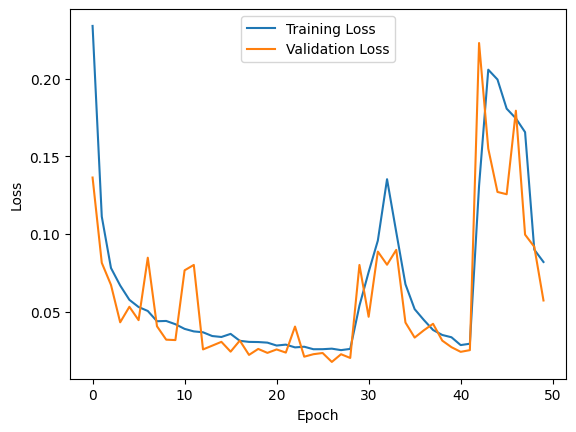

In [20]:
plot_history(delay_history)

In [21]:
joblib.dump(delay_GRUmodel, './delayGRU_softmax_rebalanced_plus_minmax_sliding.pkl')

['./delayGRU_softmax_rebalanced_plus_minmax_sliding.pkl']

### Gain

In [22]:
gain_GRUmodel = build_model(num_classes=2, units=120, learning_rate=0.001, momentum=0.99, optimizer='adam', dropout=0.2)
gain_history = gain_GRUmodel.fit(gainX_train, gainY_train,batch_size=20, epochs=100, validation_data=(gainX_val, gainY_val))


Epoch 1/100
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 141s 20ms/step - accuracy: 0.8081 - loss: 0.3909 - val_accuracy: 0.8009 - val_loss: 0.3696
Epoch 2/100
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 140s 20ms/step - accuracy: 0.8445 - loss: 0.3091 - val_accuracy: 0.8824 - val_loss: 0.2251
Epoch 3/100
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 140s 20ms/step - accuracy: 0.8831 - loss: 0.2314 - val_accuracy: 0.8581 - val_loss: 0.2538
Epoch 4/100
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 141s 20ms/step - accuracy: 0.8970 - loss: 0.2125 - val_accuracy: 0.9234 - val_loss: 0.1621
Epoch 5/100
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - accuracy: 0.9126 - loss: 0.1925 - val_accuracy: 0.8746 - val_loss: 0.2009
Epoch 6/100
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - accuracy: 0.9291 - loss: 0.1637 - val_accuracy: 0.9419 - val_loss: 0.1213
Epoch 7/100
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 140s 20ms/step - accuracy: 0.9393 - loss: 0.1447 - val_accuracy: 0.9286 - val_loss: 0.1327
Epoch 8/100
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 141s 20ms/step - ac

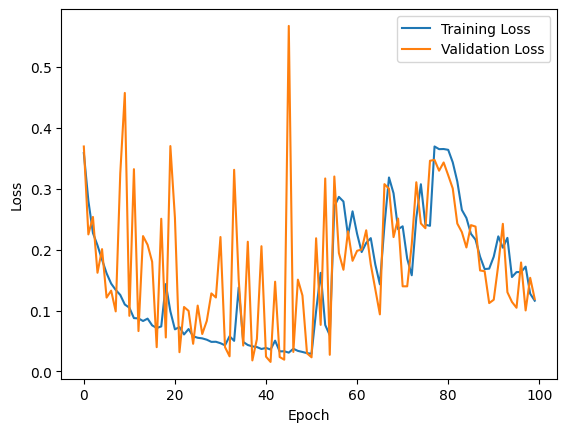

In [23]:
plot_history(gain_history)

In [24]:
joblib.dump(gain_GRUmodel, './gainGRU_softmax_rebalanced_plus_minmax_sliding.pkl')

['./gainGRU_softmax_rebalanced_plus_minmax_sliding.pkl']

### Noise

In [25]:
noise_GRUmodel = build_model(num_classes=2, units=120, learning_rate=0.001, momentum=0.99, optimizer='adam', dropout=0.2)
noise_history = noise_GRUmodel.fit(noiseX_train, noiseY_train,batch_size=20, epochs=50, validation_data=(noiseX_val, noiseY_val))


Epoch 1/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - accuracy: 0.8501 - loss: 0.3314 - val_accuracy: 0.8945 - val_loss: 0.2151
Epoch 2/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 141s 20ms/step - accuracy: 0.8847 - loss: 0.2475 - val_accuracy: 0.8935 - val_loss: 0.2002
Epoch 3/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 140s 20ms/step - accuracy: 0.8939 - loss: 0.2117 - val_accuracy: 0.9027 - val_loss: 0.1914
Epoch 4/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 140s 20ms/step - accuracy: 0.9022 - loss: 0.1930 - val_accuracy: 0.9117 - val_loss: 0.1630
Epoch 5/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 140s 20ms/step - accuracy: 0.9092 - loss: 0.1775 - val_accuracy: 0.9219 - val_loss: 0.1547
Epoch 6/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - accuracy: 0.9161 - loss: 0.1626 - val_accuracy: 0.9190 - val_loss: 0.1709
Epoch 7/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 140s 20ms/step - accuracy: 0.9195 - loss: 0.1584 - val_accuracy: 0.9129 - val_loss: 0.1661
Epoch 8/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 140s 20ms/step - accuracy: 

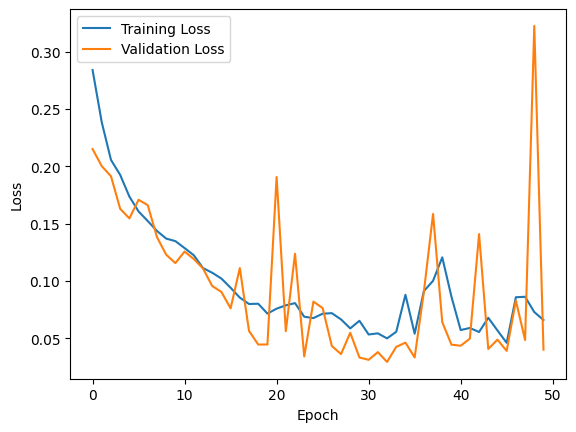

In [26]:
plot_history(noise_history)

In [27]:
joblib.dump(noise_GRUmodel, './noiseGRU_softmax_rebalanced_plus_minmax_sliding.pkl')

['./noiseGRU_softmax_rebalanced_plus_minmax_sliding.pkl']

### Packet Loss

In [28]:
packetLoss_GRUmodel = build_model(num_classes=2, units=120, learning_rate=0.001, momentum=0.99, optimizer='adam', dropout=0.2)
packetLoss_history = packetLoss_GRUmodel.fit(packetLossX_train, packetLossY_train,batch_size=20, epochs=50, validation_data=(packetLossX_val, packetLossY_val))


Epoch 1/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 208s 29ms/step - accuracy: 0.9417 - loss: 0.1611 - val_accuracy: 0.9927 - val_loss: 0.0220
Epoch 2/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 205s 29ms/step - accuracy: 0.9882 - loss: 0.0371 - val_accuracy: 0.9956 - val_loss: 0.0135
Epoch 3/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 205s 29ms/step - accuracy: 0.9922 - loss: 0.0242 - val_accuracy: 0.9955 - val_loss: 0.0237
Epoch 4/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 205s 29ms/step - accuracy: 0.9927 - loss: 0.0220 - val_accuracy: 0.9965 - val_loss: 0.0090
Epoch 5/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 205s 29ms/step - accuracy: 0.9937 - loss: 0.0194 - val_accuracy: 0.9956 - val_loss: 0.0141
Epoch 6/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 205s 29ms/step - accuracy: 0.9945 - loss: 0.0151 - val_accuracy: 0.9953 - val_loss: 0.0114
Epoch 7/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 205s 29ms/step - accuracy: 0.9933 - loss: 0.0193 - val_accuracy: 0.8512 - val_loss: 0.3318
Epoch 8/50
6996/6996 ━━━━━━━━━━━━━━━━━━━━ 203s 29ms/step - accuracy: 

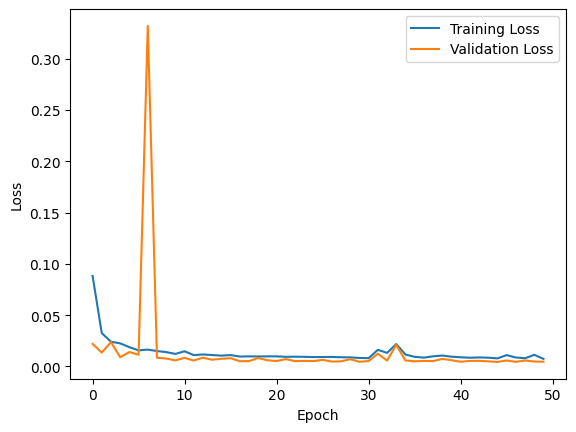

In [29]:
plot_history(packetLoss_history)

In [30]:
joblib.dump(packetLoss_GRUmodel, './packetLossGRU_softmax_rebalanced_plus_minmax_sliding.pkl')

['./packetLossGRU_softmax_rebalanced_plus_minmax_sliding.pkl']

# Evaluation

### Delay

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     25929
           1       0.90      0.93      0.92      4053

    accuracy                           0.98     29982
   macro avg       0.95      0.96      0.95     29982
weighted avg       0.98      0.98      0.98     29982

Confusion Matrix:


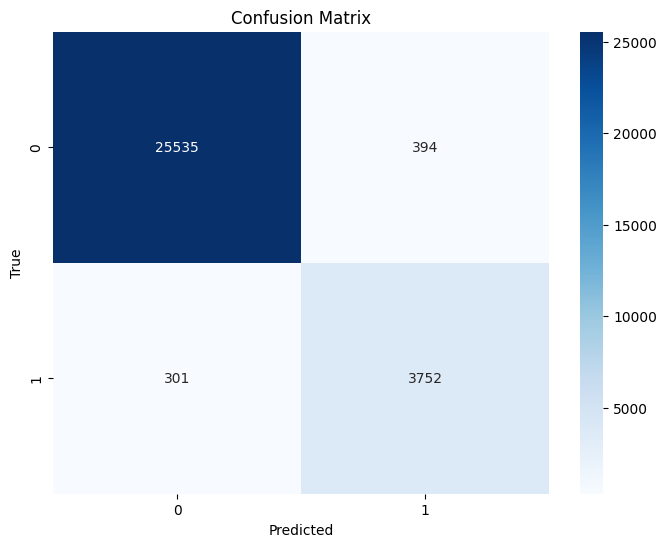

In [31]:
print("Classification Report:")
pred = delay_GRUmodel.predict(delayX_test,verbose=0)
report = generate_classificationReport(np.argmax(delayY_test,axis=1), np.argmax(pred,axis=1))
print(report)
print("Confusion Matrix:")
plot_confusion_matrix(np.argmax(delayY_test,axis=1), np.argmax(pred,axis=1), classes=[0,1], title='Confusion Matrix')

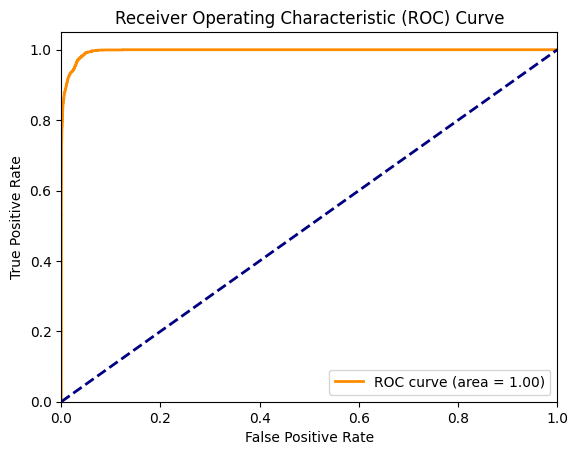

In [32]:
fpr, tpr, _ = roc_curve(np.argmax(delayY_test,axis=1),pred.T[1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Gain

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     24712
           1       0.96      0.74      0.84      5270

    accuracy                           0.95     29982
   macro avg       0.96      0.87      0.90     29982
weighted avg       0.95      0.95      0.95     29982

Confusion Matrix:


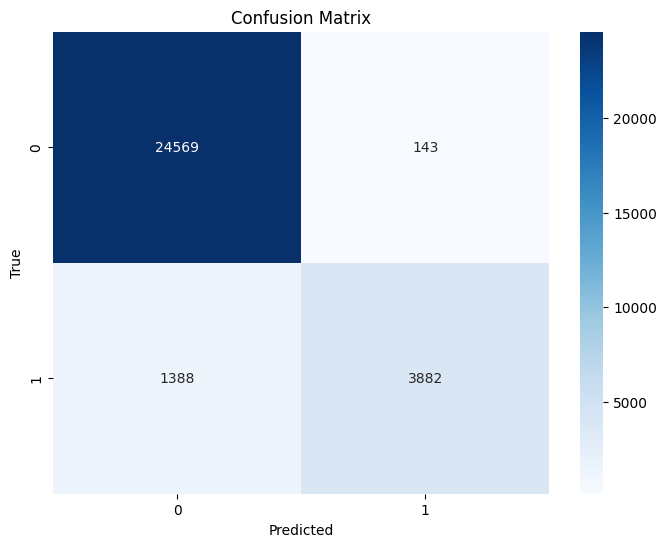

In [33]:
print("Classification Report:")
pred = gain_GRUmodel.predict(gainX_test,verbose=0)
report = generate_classificationReport(np.argmax(gainY_test,axis=1), np.argmax(pred,axis=1))
print(report)
print("Confusion Matrix:")
plot_confusion_matrix(np.argmax(gainY_test,axis=1), np.argmax(pred,axis=1), classes=[0,1], title='Confusion Matrix')

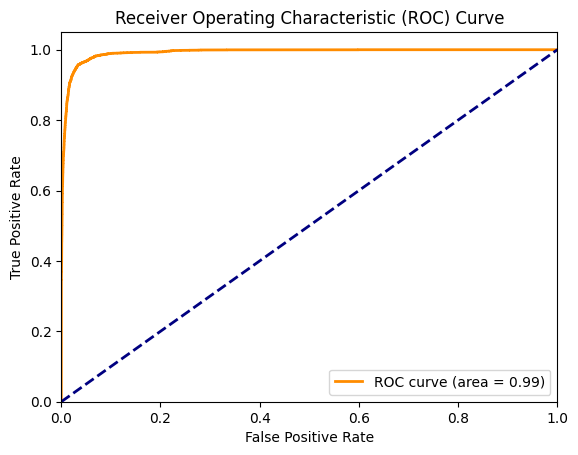

In [34]:
fpr, tpr, _ = roc_curve(np.argmax(gainY_test,axis=1),pred.T[1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Noise

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     25212
           1       0.95      0.97      0.96      4770

    accuracy                           0.99     29982
   macro avg       0.97      0.98      0.97     29982
weighted avg       0.99      0.99      0.99     29982

Confusion Matrix:


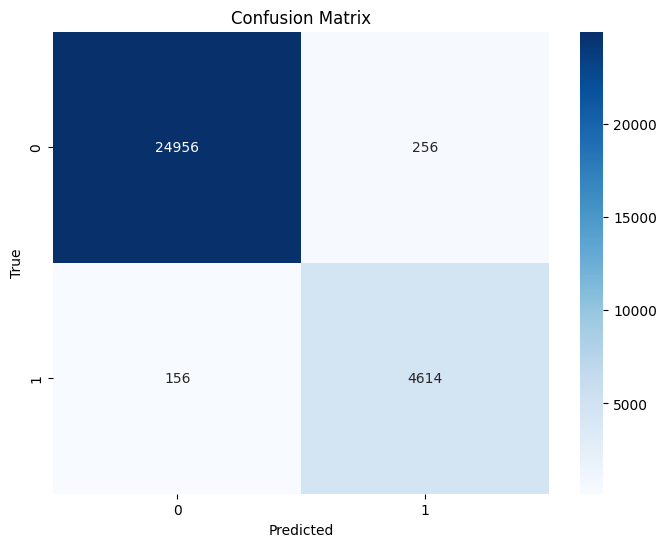

In [35]:
print("Classification Report:")
pred = noise_GRUmodel.predict(noiseX_test,verbose=0)
# y_true, pred= single_fault_voter(noiseY_test, pred)
report = generate_classificationReport(np.argmax(noiseY_test,axis=1), np.argmax(pred,axis=1))
print(report)
print("Confusion Matrix:")
plot_confusion_matrix(np.argmax(noiseY_test,axis=1), np.argmax(pred,axis=1), classes=[0,1], title='Confusion Matrix')

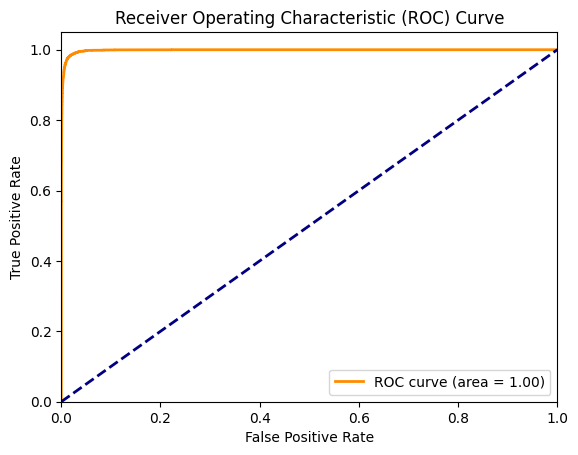

In [36]:
fpr, tpr, _ = roc_curve(np.argmax(noiseY_test,axis=1),pred.T[1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Packet Loss

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23970
           1       0.99      1.00      0.99      6012

    accuracy                           1.00     29982
   macro avg       0.99      1.00      1.00     29982
weighted avg       1.00      1.00      1.00     29982

Confusion Matrix:


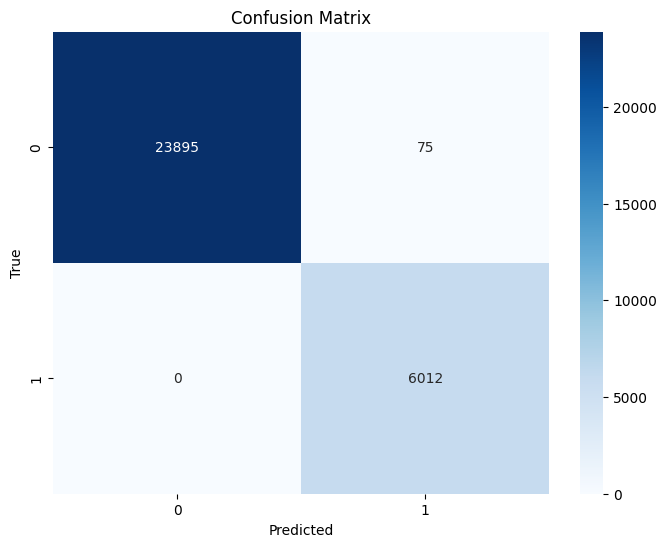

In [37]:
print("Classification Report:")
pred = packetLoss_GRUmodel.predict(packetLossX_test,verbose=0)
# y_true, pred= single_fault_voter(packetLossY_test, pred)
report = generate_classificationReport(np.argmax(packetLossY_test,axis=1), np.argmax(pred,axis=1))
print(report)
print("Confusion Matrix:")
plot_confusion_matrix(np.argmax(packetLossY_test,axis=1), np.argmax(pred,axis=1), classes=[0,1], title='Confusion Matrix')

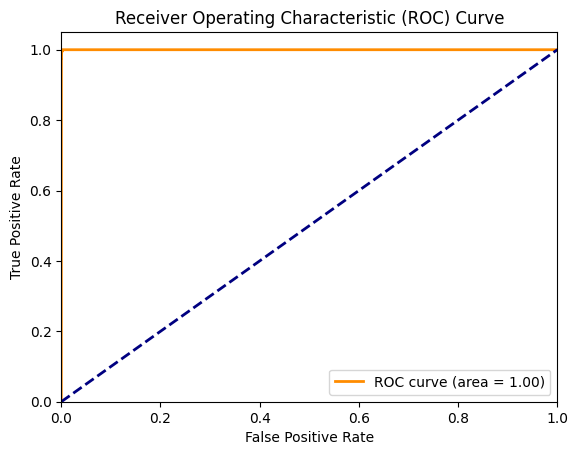

In [38]:
fpr, tpr, _ = roc_curve(np.argmax(packetLossY_test,axis=1),pred.T[1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [39]:
def sliding_sequences2(combined_data, window_size=50):
    combined_data = combined_data.copy()
    features = combined_data.columns.tolist()

    features = [f for f in features if 'Sensor Reading' in f]

    X_train_data = combined_data[features]

    scaled_X_df = (X_train_data - X_train_data.min()) / (X_train_data.max() - X_train_data.min())

    combined_data[features] = scaled_X_df

    df = combined_data

    X_train = []

    window_size = 50

    for i in range(len(df) - window_size + 1):
      temp = df[i: i + window_size]
      sequence_features = temp[features]
      X_train.append(sequence_features)



    X_train = np.array(X_train)

    return X_train

## CONCURRENT FAULTS DETECTION

In [40]:
# Importing the models
delay_GRUmodel = joblib.load('./delayGRU_softmax_rebalanced_plus_minmax_sliding.pkl')
gain_GRUmodel = joblib.load(
    './gainGRU_softmax_rebalanced_plus_minmax_sliding.pkl')
noise_GRUmodel = joblib.load('./noiseGRU_softmax_rebalanced_plus_minmax_sliding.pkl')
packetLoss_GRUmodel = joblib.load(
    './packetLossGRU_softmax_rebalanced_plus_minmax_sliding.pkl')

In [41]:

delay_data_list = []
noise_data_list = []
loss_data_list = []


file_path_gainRPM_delayAPP = './HIL Data 062024/ACC faults different scenarios/Sc3DelayAPP.csv'
file_path_gainRPM_noiseAPP = './HIL Data 062024/ACC faults different scenarios/Sc3_Noise_APP_50.csv'
file_path_gainRPM_packetlossAPP = './HIL Data 062024/ACC faults different scenarios/Sc3PacketlossAPP.csv'

ref_length = len(read_this(file_path_gainRPM_delayAPP)[2])


# TEST DATA
store_trace_values(delay_data_list, file_path_gainRPM_delayAPP, ref_length)
store_trace_values(noise_data_list, file_path_gainRPM_noiseAPP, ref_length)
store_trace_values(loss_data_list, file_path_gainRPM_packetlossAPP, ref_length)

# Combine all data lists into DataFrames
gainRPM_delayAPP = pd.concat(delay_data_list, ignore_index=True)
gainRPM_noiseAPP = pd.concat(noise_data_list, ignore_index=True)
gainRPM_packetlossAPP = pd.concat(loss_data_list, ignore_index=True)
gainRPM_delayAPP

,Sensor Reading 1,Sensor Reading 2,Sensor Reading 3,Sensor Reading 4,Sensor Reading 5,Sensor Reading 6,Sensor Reading 7,Sensor Reading 8
0,0.100004,100.000000,925.691036,1.453043,904.862764,99799.596922,119.954563,8.695555e-322
1,0.150006,100.000000,925.446918,0.923328,907.558512,99798.895199,120.062564,8.695555e-322
2,0.200008,100.000000,925.181667,0.081689,905.323550,99798.999811,120.082518,8.695555e-322
3,0.250009,100.000000,924.899068,0.093517,902.565698,99799.746020,120.033915,8.695555e-322
4,0.300012,100.000000,924.620007,0.371697,904.902615,99799.625901,119.962561,8.695555e-322
...,...,...,...,...,...,...,...,...
8011,400.651365,11.167016,999.999964,68.480873,2424.303284,47367.923527,119.984490,9.168329e+01
8012,400.701366,11.158937,999.999965,68.437356,2426.496271,47346.514553,119.982726,9.172072e+01
8013,400.751366,11.150077,999.999965,68.379213,2428.151028,47315.232617,119.980322,9.175802e+01
8014,400.801367,11.141930,999.999965,68.299941,2430.081442,47275.810884,119.980109,9.179518e+01


In [42]:
gainRPM_delayAPPX_test = sliding_sequences2(gainRPM_delayAPP,window_size=100)
gainRPM_noiseAPPX_test = sliding_sequences2(gainRPM_noiseAPP,window_size=100)
gainRPM_packetlossAPPX_test = sliding_sequences2(gainRPM_packetlossAPP,window_size=100)

# New Voter based on model confidence

In [43]:
def concurrent_voter(data):
    gain_prediction = np.argmax(gain_GRUmodel.predict(data),axis=1)
    gain_confidence = np.max(gain_GRUmodel.predict(data),axis=1)
    noise_prediction = np.argmax(noise_GRUmodel.predict(data),axis=1)
    noise_confidence = np.max(noise_GRUmodel.predict(data),axis=1)
    packetLoss_prediction = np.argmax(packetLoss_GRUmodel.predict(data),axis=1)
    packetLoss_confidence = np.max(packetLoss_GRUmodel.predict(data),axis=1)
    delay_prediction = np.argmax(delay_GRUmodel.predict(data),axis=1)
    delay_confidence = np.max(delay_GRUmodel.predict(data),axis=1)
    # Combine predictions and confidences for each classifier
    predictions = {
        "gain": gain_prediction,
        "noise": noise_prediction,
        "packetLoss": packetLoss_prediction,
        "delay": delay_prediction
    }

    confidences = {
        "gain": gain_confidence,
        "noise": noise_confidence,
        "packetLoss": packetLoss_confidence,
        "delay": delay_confidence
    }

    # Combine predictions and confidences into one array
    combined_predictions = []
    for i in range(len(gain_prediction)):
        label_confidences = {}
        for key, value in confidences.items():
            label_confidences[key] = (predictions[key][i], value[i])
        combined_predictions.append(label_confidences)

    # Select label with the highest confidence for each data point
    final_predictions = []
    for pred in combined_predictions:
        top_faults = sorted(pred, key=lambda x: pred[x][1], reverse=True)[:2]
        final_predictions.append(top_faults)

    # Convert final predictions to array
    final_predictions = np.array(final_predictions)

    return final_predictions

### TESTS USING NEW DATA

#### Gain and Delay (F2 and F1)

In [44]:
gain_delay = concurrent_voter(gainRPM_delayAPPX_test)

249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


In [45]:
(pd.DataFrame(gain_delay).iloc[:,0].value_counts().index[0],pd.DataFrame(gain_delay).iloc[:,1].value_counts().index[0])

('packetLoss', 'gain')

#### Gain and Noise (F2 and F3)

In [46]:
gain_noise = concurrent_voter(gainRPM_noiseAPPX_test)


249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


In [47]:
(pd.DataFrame(gain_noise).iloc[:,0].value_counts().index[0],pd.DataFrame(gain_noise).iloc[:,1].value_counts().index[0])

('packetLoss', 'gain')

#### Gain and Packet Loss (F2 and F4)

In [48]:
gain_packetloss = concurrent_voter(gainRPM_packetlossAPPX_test)

249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


In [49]:
(pd.DataFrame(gain_packetloss).iloc[:,0].value_counts().index[0],pd.DataFrame(gain_packetloss).iloc[:,1].value_counts().index[0])

('packetLoss', 'gain')